# Modelo Dimensional - Metodología Kimball

## Análisis y Diseño del Data Warehouse

Este notebook contiene el análisis completo para el diseño de un modelo dimensional siguiendo la metodología de Kimball, basado en las preguntas de negocio identificadas en los notebooks de análisis.


## 1. Revisión de Preguntas de Negocio

A continuación se revisan las preguntas planteadas en los notebooks dentro de la carpeta `preguntas_negocio`:


### 1.1 Preguntas de Negocio Identificadas

#### **VENTAS**
1. ¿Cuáles son los productos más vendidos por volumen?
2. ¿Cuál es el ticket promedio por orden?
3. ¿Cuáles son las categorías con mayor número de productos vendidos?
4. ¿Qué día de la semana se generan más ventas?
5. ¿Cuántas órdenes se generan cada mes y cuál es su variación?

#### **PAGOS Y TRANSACCIONES**
1. ¿Cuáles son los métodos de pago más utilizados?
2. ¿Cuál es el monto promedio pagado por método de pago?
3. ¿Cuántas órdenes se pagaron usando más de un método de pago?
4. ¿Cuántos pagos están en estado 'Procesando' o 'Fallido'?
5. ¿Cuál es el monto total recaudado por mes?

#### **USUARIOS**
1. ¿Cuántos usuarios se registran por mes?
2. ¿Cuántos usuarios han realizado más de una orden?
3. ¿Cuántos usuarios registrados no han hecho ninguna compra?
4. ¿Qué usuarios han gastado más en total?
5. ¿Cuántos usuarios han dejado reseñas?

#### **PRODUCTOS Y STOCK**
1. ¿Qué productos tienen alto stock pero bajas ventas?
2. ¿Cuántos productos están actualmente fuera de stock?
3. ¿Cuáles son los productos peor calificados?
4. ¿Qué productos tienen mayor cantidad de reseñas?
5. ¿Qué categoría tiene el mayor valor económico vendido (no solo volumen)?

```


## 2. Identificación de Medidas y Dimensiones

### 2.1 Análisis de Información Necesaria

Para responder a las preguntas de negocio, necesitamos analizar:

**Medidas Cuantitativas (Hechos):**
- Cantidad de productos vendidos
- Monto total de ventas
- Número de órdenes
- Ticket promedio
- Cantidad de usuarios
- Número de reseñas
- Calificaciones promedio
- Stock disponible
- Montos de pago
- Cantidad de transacciones

**Dimensiones (Atributos Descriptivos):**
- **Tiempo**: Fecha, mes, año, día de la semana, trimestre
- **Producto**: Nombre, precio, categoría, stock
- **Cliente/Usuario**: Nombre, email, fecha de registro, ubicación
- **Categoría**: Nombre, descripción
- **Método de Pago**: Nombre, descripción
- **Estado**: Estado de orden, estado de pago
- **Geografía**: Ciudad, provincia, país



## 3. Esquema Conceptual del Modelo

### 3.1 Entidades Principales

El modelo conceptual identifica las siguientes entidades principales:

1. **Ventas/Órdenes**: Representa las transacciones de venta
2. **Pagos**: Representa las transacciones de pago
3. **Reseñas**: Representa las interacciones de los clientes con productos
4. **Usuarios**: Representa los clientes del sistema
5. **Productos**: Representa el catálogo de productos
6. **Categorías**: Representa la clasificación de productos
7. **Métodos de Pago**: Representa las formas de pago disponibles
8. **Direcciones**: Representa la información geográfica

### 3.2 Relaciones y Cardinalidades

```
USUARIOS (1) ────< (N) ÓRDENES
USUARIOS (1) ────< (N) RESEÑAS
USUARIOS (1) ────< (N) DIRECCIONES_ENVIO

PRODUCTOS (1) ────< (N) DETALLE_ORDENES
PRODUCTOS (1) ────< (N) RESEÑAS
PRODUCTOS (N) ────> (1) CATEGORIAS

ÓRDENES (1) ────< (N) DETALLE_ORDENES
ÓRDENES (1) ────< (N) ORDENES_METODOS_PAGO
ÓRDENES (1) ────< (N) HISTORIAL_PAGOS

METODOS_PAGO (1) ────< (N) ORDENES_METODOS_PAGO
METODOS_PAGO (1) ────< (N) HISTORIAL_PAGOS
```

### 3.3 Diagrama Conceptual Simplificado

```
┌─────────────┐
│  USUARIOS   │
└──────┬──────┘
       │
       │ 1:N
       │
┌──────▼──────┐      ┌──────────────┐
│   ÓRDENES   │──────│ DETALLE_ORDEN│
└──────┬──────┘ 1:N  └──────┬───────┘
       │                    │
       │ 1:N                │ N:1
       │                    │
┌──────▼──────────┐    ┌────▼──────┐
│ ORDENES_METODOS │    │ PRODUCTOS │
│      PAGO       │    └─────┬─────┘
└──────┬──────────┘          │
       │                      │ N:1
       │ N:1                  │
┌──────▼──────┐          ┌────▼──────┐
│ METODOS_PAGO│          │ CATEGORIAS│
└─────────────┘          └───────────┘

## 4. Modelo Lógico - Hechos y Dimensiones (Metodología Kimball)

### 4.0 Dimensiones Detalladas

#### **1. Dimensión de Tiempo (Dim_Tiempo)**
**Atributos:**
- `tiempo_id` (PK): Clave sustituta
- `fecha` (DATE): Fecha completa
- `dia` (INTEGER): Día del mes (1-31)
- `mes` (INTEGER): Mes (1-12)
- `año` (INTEGER): Año (YYYY)
- `trimestre` (INTEGER): Trimestre (1-4)
- `semana_año` (INTEGER): Semana del año (1-53)
- `dia_semana` (INTEGER): Día de la semana (1=Lunes, 7=Domingo)
- `nombre_dia` (VARCHAR): Nombre del día (Lunes, Martes, etc.)
- `nombre_mes` (VARCHAR): Nombre del mes (Enero, Febrero, etc.)
- `es_fin_semana` (BOOLEAN): Indicador si es fin de semana
- `es_feriado` (BOOLEAN): Indicador si es día feriado
- `mes_año` (VARCHAR): Formato "YYYY-MM"
- `trimestre_año` (VARCHAR): Formato "YYYY-Q"

**Uso**: Filtrar y agrupar por períodos de tiempo, análisis de tendencias temporales

#### **2. Dimensión de Producto (Dim_Producto)**
**Atributos:**
- `producto_id` (PK): Clave sustituta (surrogate key)
- `producto_natural_key` (INTEGER): ID del producto en el sistema fuente
- `nombre` (VARCHAR): Nombre del producto
- `descripcion` (TEXT): Descripción del producto
- `precio_actual` (DECIMAL): Precio actual del producto
- `stock_actual` (INTEGER): Stock actual
- `categoria_id` (FK): Referencia a Dim_Categoria
- `categoria_nombre` (VARCHAR): Nombre de la categoría (denormalizado para performance)
- `fecha_creacion` (DATE): Fecha de creación del producto
- `activo` (BOOLEAN): Si el producto está activo

**Uso**: Filtrar por producto, categoría, análisis de productos más/menos vendidos

#### **3. Dimensión de Cliente/Usuario (Dim_Cliente)**
**Atributos:**
- `cliente_id` (PK): Clave sustituta
- `usuario_natural_key` (INTEGER): ID del usuario en el sistema fuente
- `nombre` (VARCHAR): Nombre del cliente
- `apellido` (VARCHAR): Apellido del cliente
- `nombre_completo` (VARCHAR): Nombre completo (denormalizado)
- `email` (VARCHAR): Email del cliente
- `dni` (VARCHAR): DNI del cliente
- `fecha_registro` (DATE): Fecha de registro
- `años_cliente` (INTEGER): Años desde el registro
- `segmento_cliente` (VARCHAR): Segmento (Nuevo, Recurrente, VIP, etc.)
- `direccion_principal_id` (FK): Referencia a dirección principal

**Uso**: Segmentación de clientes, análisis de comportamiento, CLV (Customer Lifetime Value)

#### **4. Dimensión de Categoría (Dim_Categoria)**
**Atributos:**
- `categoria_id` (PK): Clave sustituta
- `categoria_natural_key` (INTEGER): ID de la categoría en el sistema fuente
- `nombre` (VARCHAR): Nombre de la categoría
- `descripcion` (TEXT): Descripción de la categoría
- `categoria_padre_id` (FK): Para jerarquías (si aplica)
- `nivel` (INTEGER): Nivel en la jerarquía

**Uso**: Análisis por categoría, comparación entre categorías

#### **5. Dimensión de Método de Pago (Dim_Metodo_Pago)**
**Atributos:**
- `metodo_pago_id` (PK): Clave sustituta
- `metodo_pago_natural_key` (INTEGER): ID del método en el sistema fuente
- `nombre` (VARCHAR): Nombre del método de pago
- `descripcion` (TEXT): Descripción del método
- `tipo_metodo` (VARCHAR): Tipo (Tarjeta, Efectivo, Transferencia, etc.)
- `requiere_verificacion` (BOOLEAN): Si requiere verificación adicional

**Uso**: Análisis de métodos de pago preferidos, comparación de métodos

#### **6. Dimensión de Estado de Orden (Dim_Estado_Orden)**
**Atributos:**
- `estado_id` (PK): Clave sustituta
- `estado_nombre` (VARCHAR): Nombre del estado (Pendiente, Completada, Cancelada, etc.)
- `descripcion` (TEXT): Descripción del estado
- `es_final` (BOOLEAN): Si es un estado final
- `permite_modificacion` (BOOLEAN): Si permite modificación

**Uso**: Análisis de estados de órdenes, tasas de conversión

#### **7. Dimensión de Estado de Pago (Dim_Estado_Pago)**
**Atributos:**
- `estado_pago_id` (PK): Clave sustituta
- `estado_nombre` (VARCHAR): Nombre del estado (Pagado, Procesando, Fallido, Reembolsado)
- `descripcion` (TEXT): Descripción del estado
- `es_exitoso` (BOOLEAN): Si el pago fue exitoso
- `requiere_accion` (BOOLEAN): Si requiere acción del usuario/administrador

**Uso**: Análisis de estados de pago, identificación de problemas

#### **8. Dimensión Geográfica (Dim_Geografia)**
**Atributos:**
- `geografia_id` (PK): Clave sustituta
- `direccion_id` (INTEGER): ID de la dirección (natural key)
- `calle` (VARCHAR): Calle
- `ciudad` (VARCHAR): Ciudad
- `provincia` (VARCHAR): Provincia/Estado
- `pais` (VARCHAR): País
- `codigo_postal` (VARCHAR): Código postal
- `region` (VARCHAR): Región (si aplica)

**Uso**: Análisis geográfico de ventas, segmentación por ubicación

### 4.1 Hechos Centrales Identificados

Basado en el análisis de las preguntas de negocio, se identifican los siguientes hechos centrales:

#### **1. Hecho de Ventas (Fact_Ventas)**
- **Propósito**: Analizar las transacciones de venta
- **Granularidad**: Una fila por cada línea de detalle de orden (detalle_ordenes)
- **Responda a**: Preguntas sobre productos vendidos, categorías, ticket promedio, ventas por tiempo

#### **2. Hecho de Pagos (Fact_Pagos)**
- **Propósito**: Analizar las transacciones de pago
- **Granularidad**: Una fila por cada transacción de pago (historial_pagos)
- **Responda a**: Preguntas sobre métodos de pago, montos, estados de pago, recaudación

#### **3. Hecho de Reseñas (Fact_Resenas)**
- **Propósito**: Analizar las interacciones de los clientes con productos
- **Granularidad**: Una fila por cada reseña (resenas_productos)
- **Responda a**: Preguntas sobre calificaciones, productos mejor/peor calificados, participación de usuarios

#### **4. Hecho de Usuarios (Fact_Usuarios) - Tabla de Hechos Acumulativa**
- **Propósito**: Analizar el comportamiento y características de los usuarios
- **Granularidad**: Una fila por usuario con métricas agregadas
- **Responda a**: Preguntas sobre usuarios registrados, usuarios con compras, usuarios con reseñas

### 4.2 Medidas Cuantitativas Asociadas

#### **Fact_Ventas - Medidas:**
- `cantidad_vendida` (INTEGER): Cantidad de productos vendidos
- `precio_unitario` (DECIMAL): Precio unitario al momento de la venta
- `subtotal` (DECIMAL): Cantidad × Precio unitario
- `descuento` (DECIMAL): Descuento aplicado (si existe)
- `total_linea` (DECIMAL): Subtotal - Descuento

#### **Fact_Pagos - Medidas:**
- `monto_pagado` (DECIMAL): Monto de la transacción de pago
- `cantidad_transacciones` (INTEGER): Contador de transacciones (si se agrega)

#### **Fact_Resenas - Medidas:**
- `calificacion` (INTEGER): Calificación de 1 a 5
- `tiene_comentario` (BOOLEAN): Indicador si tiene comentario
- `longitud_comentario` (INTEGER): Longitud del comentario en caracteres

#### **Fact_Usuarios - Medidas (Acumulativas):**
- `total_ordenes` (INTEGER): Total de órdenes realizadas
- `total_gastado` (DECIMAL): Suma total gastada
- `total_resenas` (INTEGER): Total de reseñas realizadas
- `fecha_primera_compra` (DATE): Fecha de la primera compra
- `fecha_ultima_compra` (DATE): Fecha de la última compra


## 5. Análisis de Dimensiones que Requieren Historial (SCD)

### 5.1 Dimensiones que Cambian en el Tiempo

#### **1. Dim_Producto - SCD Tipo 2 (Historial Completo)**
**Justificación:**
- El precio de los productos puede cambiar con el tiempo
- El stock cambia constantemente
- Necesitamos mantener historial para análisis históricos precisos
- Ejemplo: "¿Cuál era el precio del producto X en enero vs junio?"

**Estrategia SCD Tipo 2:**
- Agregar campos: `fecha_inicio_validez`, `fecha_fin_validez`, `es_actual`
- Crear nueva fila cada vez que cambie precio o stock significativamente
- Mantener todas las versiones históricas
- `es_actual = TRUE` para la versión actual

**Atributos que cambian:**
- `precio_actual` → Historial de precios
- `stock_actual` → Historial de stock (opcional, puede ser snapshot diario)

#### **2. Dim_Cliente - SCD Tipo 2 (Historial Parcial)**
**Justificación:**
- Los datos demográficos del cliente pueden cambiar (email, dirección)
- El segmento del cliente puede cambiar (Nuevo → Recurrente → VIP)
- Necesitamos rastrear cambios para análisis de comportamiento

**Estrategia SCD Tipo 2:**
- Agregar campos: `fecha_inicio_validez`, `fecha_fin_validez`, `es_actual`
- Crear nueva fila cuando cambien datos importantes (segmento, email)
- Mantener historial de cambios de segmentación

**Atributos que cambian:**
- `segmento_cliente` → Historial de segmentación
- `email` → Historial de emails (si es relevante para análisis)

#### **3. Dim_Categoria - SCD Tipo 1 (Sin Historial)**
**Justificación:**
- Las categorías raramente cambian
- Si cambian, generalmente es una corrección de datos
- No necesitamos historial de cambios de categorías

**Estrategia SCD Tipo 1:**
- Actualizar directamente los registros
- No mantener historial

#### **4. Dim_Metodo_Pago - SCD Tipo 1 (Sin Historial)**
**Justificación:**
- Los métodos de pago son relativamente estables
- Cambios son infrecuentes y generalmente son correcciones

**Estrategia SCD Tipo 1:**
- Actualizar directamente los registros

#### **5. Dim_Tiempo - Dimensión Estática**
**Justificación:**
- El tiempo no cambia, es una dimensión pre-cargada
- Se genera una vez y se mantiene estática

**Estrategia:**
- Tabla pre-poblada con todos los días del rango de análisis
- No requiere SCD

#### **6. Dim_Geografia - SCD Tipo 1 o 2 (Según Necesidad)**
**Justificación:**
- Las direcciones pueden cambiar pero generalmente son correcciones
- Si se necesita historial de ubicaciones de clientes, usar SCD Tipo 2

**Estrategia:**
- SCD Tipo 1 si solo son correcciones
- SCD Tipo 2 si se necesita historial de ubicaciones de clientes

### 5.2 Resumen de Estrategias SCD

| Dimensión | Tipo SCD | Justificación |
|-----------|----------|--------------|
| Dim_Tiempo | Estática | No cambia |
| Dim_Producto | Tipo 2 | Precio y stock cambian frecuentemente |
| Dim_Cliente | Tipo 2 | Segmento y datos pueden cambiar |
| Dim_Categoria | Tipo 1 | Cambios raros, no requieren historial |
| Dim_Metodo_Pago | Tipo 1 | Cambios raros |
| Dim_Estado_Orden | Tipo 1 | Valores fijos |
| Dim_Estado_Pago | Tipo 1 | Valores fijos |
| Dim_Geografia | Tipo 1/2 | Depende de necesidad de historial |


## 6. Estructura del Diagrama ER del Modelo Lógico

### 6.1 Tablas de Hechos (Fact Tables)

#### **Fact_Ventas**
```
Fact_Ventas
├── venta_id (PK, Surrogate Key)
├── tiempo_id (FK → Dim_Tiempo)
├── producto_id (FK → Dim_Producto)
├── cliente_id (FK → Dim_Cliente)
├── categoria_id (FK → Dim_Categoria)
├── estado_orden_id (FK → Dim_Estado_Orden)
├── geografia_id (FK → Dim_Geografia) [Opcional]
├── orden_id (Natural Key, para referencia)
├── cantidad_vendida (Measure)
├── precio_unitario (Measure)
├── subtotal (Measure)
├── descuento (Measure)
├── total_linea (Measure)
└── fecha_venta (Timestamp)
```

#### **Fact_Pagos**
```
Fact_Pagos
├── pago_id (PK, Surrogate Key)
├── tiempo_id (FK → Dim_Tiempo)
├── cliente_id (FK → Dim_Cliente)
├── metodo_pago_id (FK → Dim_Metodo_Pago)
├── estado_pago_id (FK → Dim_Estado_Pago)
├── orden_id (Natural Key, para referencia)
├── monto_pagado (Measure)
├── fecha_pago (Timestamp)
└── numero_intento (INTEGER) [Si se permite reintentos]
```

#### **Fact_Resenas**
```
Fact_Resenas
├── resena_id (PK, Surrogate Key)
├── tiempo_id (FK → Dim_Tiempo)
├── producto_id (FK → Dim_Producto)
├── cliente_id (FK → Dim_Cliente)
├── categoria_id (FK → Dim_Categoria)
├── calificacion (Measure)
├── tiene_comentario (Measure)
├── longitud_comentario (Measure)
└── fecha_resena (Timestamp)
```

#### **Fact_Usuarios (Tabla Acumulativa)**
```
Fact_Usuarios
├── usuario_id (PK, Surrogate Key)
├── cliente_id (FK → Dim_Cliente)
├── tiempo_registro_id (FK → Dim_Tiempo)
├── tiempo_primera_compra_id (FK → Dim_Tiempo) [Nullable]
├── tiempo_ultima_compra_id (FK → Dim_Tiempo) [Nullable]
├── total_ordenes (Measure)
├── total_gastado (Measure)
├── total_resenas (Measure)
├── ticket_promedio (Measure)
└── fecha_actualizacion (Timestamp)
```

### 6.2 Tablas de Dimensiones (Dimension Tables)

#### **Dim_Tiempo**
```
Dim_Tiempo
├── tiempo_id (PK)
├── fecha (DATE, Unique)
├── dia, mes, año (INTEGER)
├── trimestre, semana_año (INTEGER)
├── dia_semana (INTEGER)
├── nombre_dia, nombre_mes (VARCHAR)
├── es_fin_semana, es_feriado (BOOLEAN)
└── mes_año, trimestre_año (VARCHAR)
```

#### **Dim_Producto (SCD Tipo 2)**
```
Dim_Producto
├── producto_id (PK, Surrogate Key)
├── producto_natural_key (INTEGER)
├── nombre, descripcion (VARCHAR/TEXT)
├── precio_actual (DECIMAL)
├── stock_actual (INTEGER)
├── categoria_id (FK → Dim_Categoria)
├── categoria_nombre (VARCHAR) [Denormalizado]
├── fecha_creacion (DATE)
├── activo (BOOLEAN)
├── fecha_inicio_validez (DATE) [SCD Tipo 2]
├── fecha_fin_validez (DATE) [SCD Tipo 2]
└── es_actual (BOOLEAN) [SCD Tipo 2]
```

#### **Dim_Cliente (SCD Tipo 2)**
```
Dim_Cliente
├── cliente_id (PK, Surrogate Key)
├── usuario_natural_key (INTEGER)
├── nombre, apellido, nombre_completo (VARCHAR)
├── email, dni (VARCHAR)
├── fecha_registro (DATE)
├── años_cliente (INTEGER)
├── segmento_cliente (VARCHAR)
├── direccion_principal_id (FK)
├── fecha_inicio_validez (DATE) [SCD Tipo 2]
├── fecha_fin_validez (DATE) [SCD Tipo 2]
└── es_actual (BOOLEAN) [SCD Tipo 2]
```

#### **Dim_Categoria (SCD Tipo 1)**
```
Dim_Categoria
├── categoria_id (PK)
├── categoria_natural_key (INTEGER)
├── nombre (VARCHAR)
├── descripcion (TEXT)
├── categoria_padre_id (FK → Dim_Categoria) [Nullable]
└── nivel (INTEGER)
```

#### **Dim_Metodo_Pago (SCD Tipo 1)**
```
Dim_Metodo_Pago
├── metodo_pago_id (PK)
├── metodo_pago_natural_key (INTEGER)
├── nombre (VARCHAR)
├── descripcion (TEXT)
├── tipo_metodo (VARCHAR)
└── requiere_verificacion (BOOLEAN)
```

#### **Dim_Estado_Orden**
```
Dim_Estado_Orden
├── estado_id (PK)
├── estado_nombre (VARCHAR, Unique)
├── descripcion (TEXT)
├── es_final (BOOLEAN)
└── permite_modificacion (BOOLEAN)
```

#### **Dim_Estado_Pago**
```
Dim_Estado_Pago
├── estado_pago_id (PK)
├── estado_nombre (VARCHAR, Unique)
├── descripcion (TEXT)
├── es_exitoso (BOOLEAN)
└── requiere_accion (BOOLEAN)
```

#### **Dim_Geografia**
```
Dim_Geografia
├── geografia_id (PK)
├── direccion_id (INTEGER)
├── calle, ciudad, provincia (VARCHAR)
├── pais, codigo_postal (VARCHAR)
└── region (VARCHAR)
```

### 6.3 Diagrama ER Visual del Modelo Dimensional

```
                    ┌──────────────┐
                    │  Dim_Tiempo  │
                    └──────┬───────┘
                           │
        ┌──────────────────┼──────────────────┐
        │                  │                  │
        │                  │                  │
┌───────▼───────┐  ┌───────▼───────┐  ┌───────▼───────┐
│ Fact_Ventas   │  │  Fact_Pagos   │  │ Fact_Resenas  │
├───────────────┤  ├───────────────┤  ├───────────────┤
│ venta_id (PK)│  │ pago_id (PK)  │  │ resena_id(PK) │
│ tiempo_id(FK)│  │ tiempo_id(FK)  │  │ tiempo_id(FK) │
│ producto_id  │  │ cliente_id(FK) │  │ producto_id   │
│ cliente_id   │  │ metodo_pago   │  │ cliente_id    │
│ categoria_id │  │ estado_pago    │  │ categoria_id  │
│ cantidad     │  │ monto_pagado  │  │ calificacion  │
│ precio_unit  │  └───────┬───────┘  └───────┬───────┘
│ total_linea  │          │                  │
└───────┬───────┘          │                  │
        │                  │                  │
        │                  │                  │
        └──────────────────┼──────────────────┘
                           │
        ┌──────────────────┼──────────────────┐
        │                  │                  │
┌───────▼───────┐  ┌───────▼───────┐  ┌───────▼───────┐
│Dim_Producto  │  │ Dim_Cliente   │  │Dim_Categoria  │
│ (SCD Tipo 2) │  │ (SCD Tipo 2)  │  │ (SCD Tipo 1)  │
└───────┬───────┘  └───────────────┘  └───────┬───────┘
        │                                     │
        └─────────────────┬───────────────────┘
                          │
                  ┌───────▼───────┐
                  │Dim_Metodo_Pago│
                  │ (SCD Tipo 1)  │
                  └───────────────┘
```

### 6.4 Relaciones Clave

**Fact_Ventas:**
- Muchos a Uno con Dim_Tiempo
- Muchos a Uno con Dim_Producto
- Muchos a Uno con Dim_Cliente
- Muchos a Uno con Dim_Categoria
- Muchos a Uno con Dim_Estado_Orden
- Muchos a Uno con Dim_Geografia (opcional)

**Fact_Pagos:**
- Muchos a Uno con Dim_Tiempo
- Muchos a Uno con Dim_Cliente
- Muchos a Uno con Dim_Metodo_Pago
- Muchos a Uno con Dim_Estado_Pago

**Fact_Resenas:**
- Muchos a Uno con Dim_Tiempo
- Muchos a Uno con Dim_Producto
- Muchos a Uno con Dim_Cliente
- Muchos a Uno con Dim_Categoria


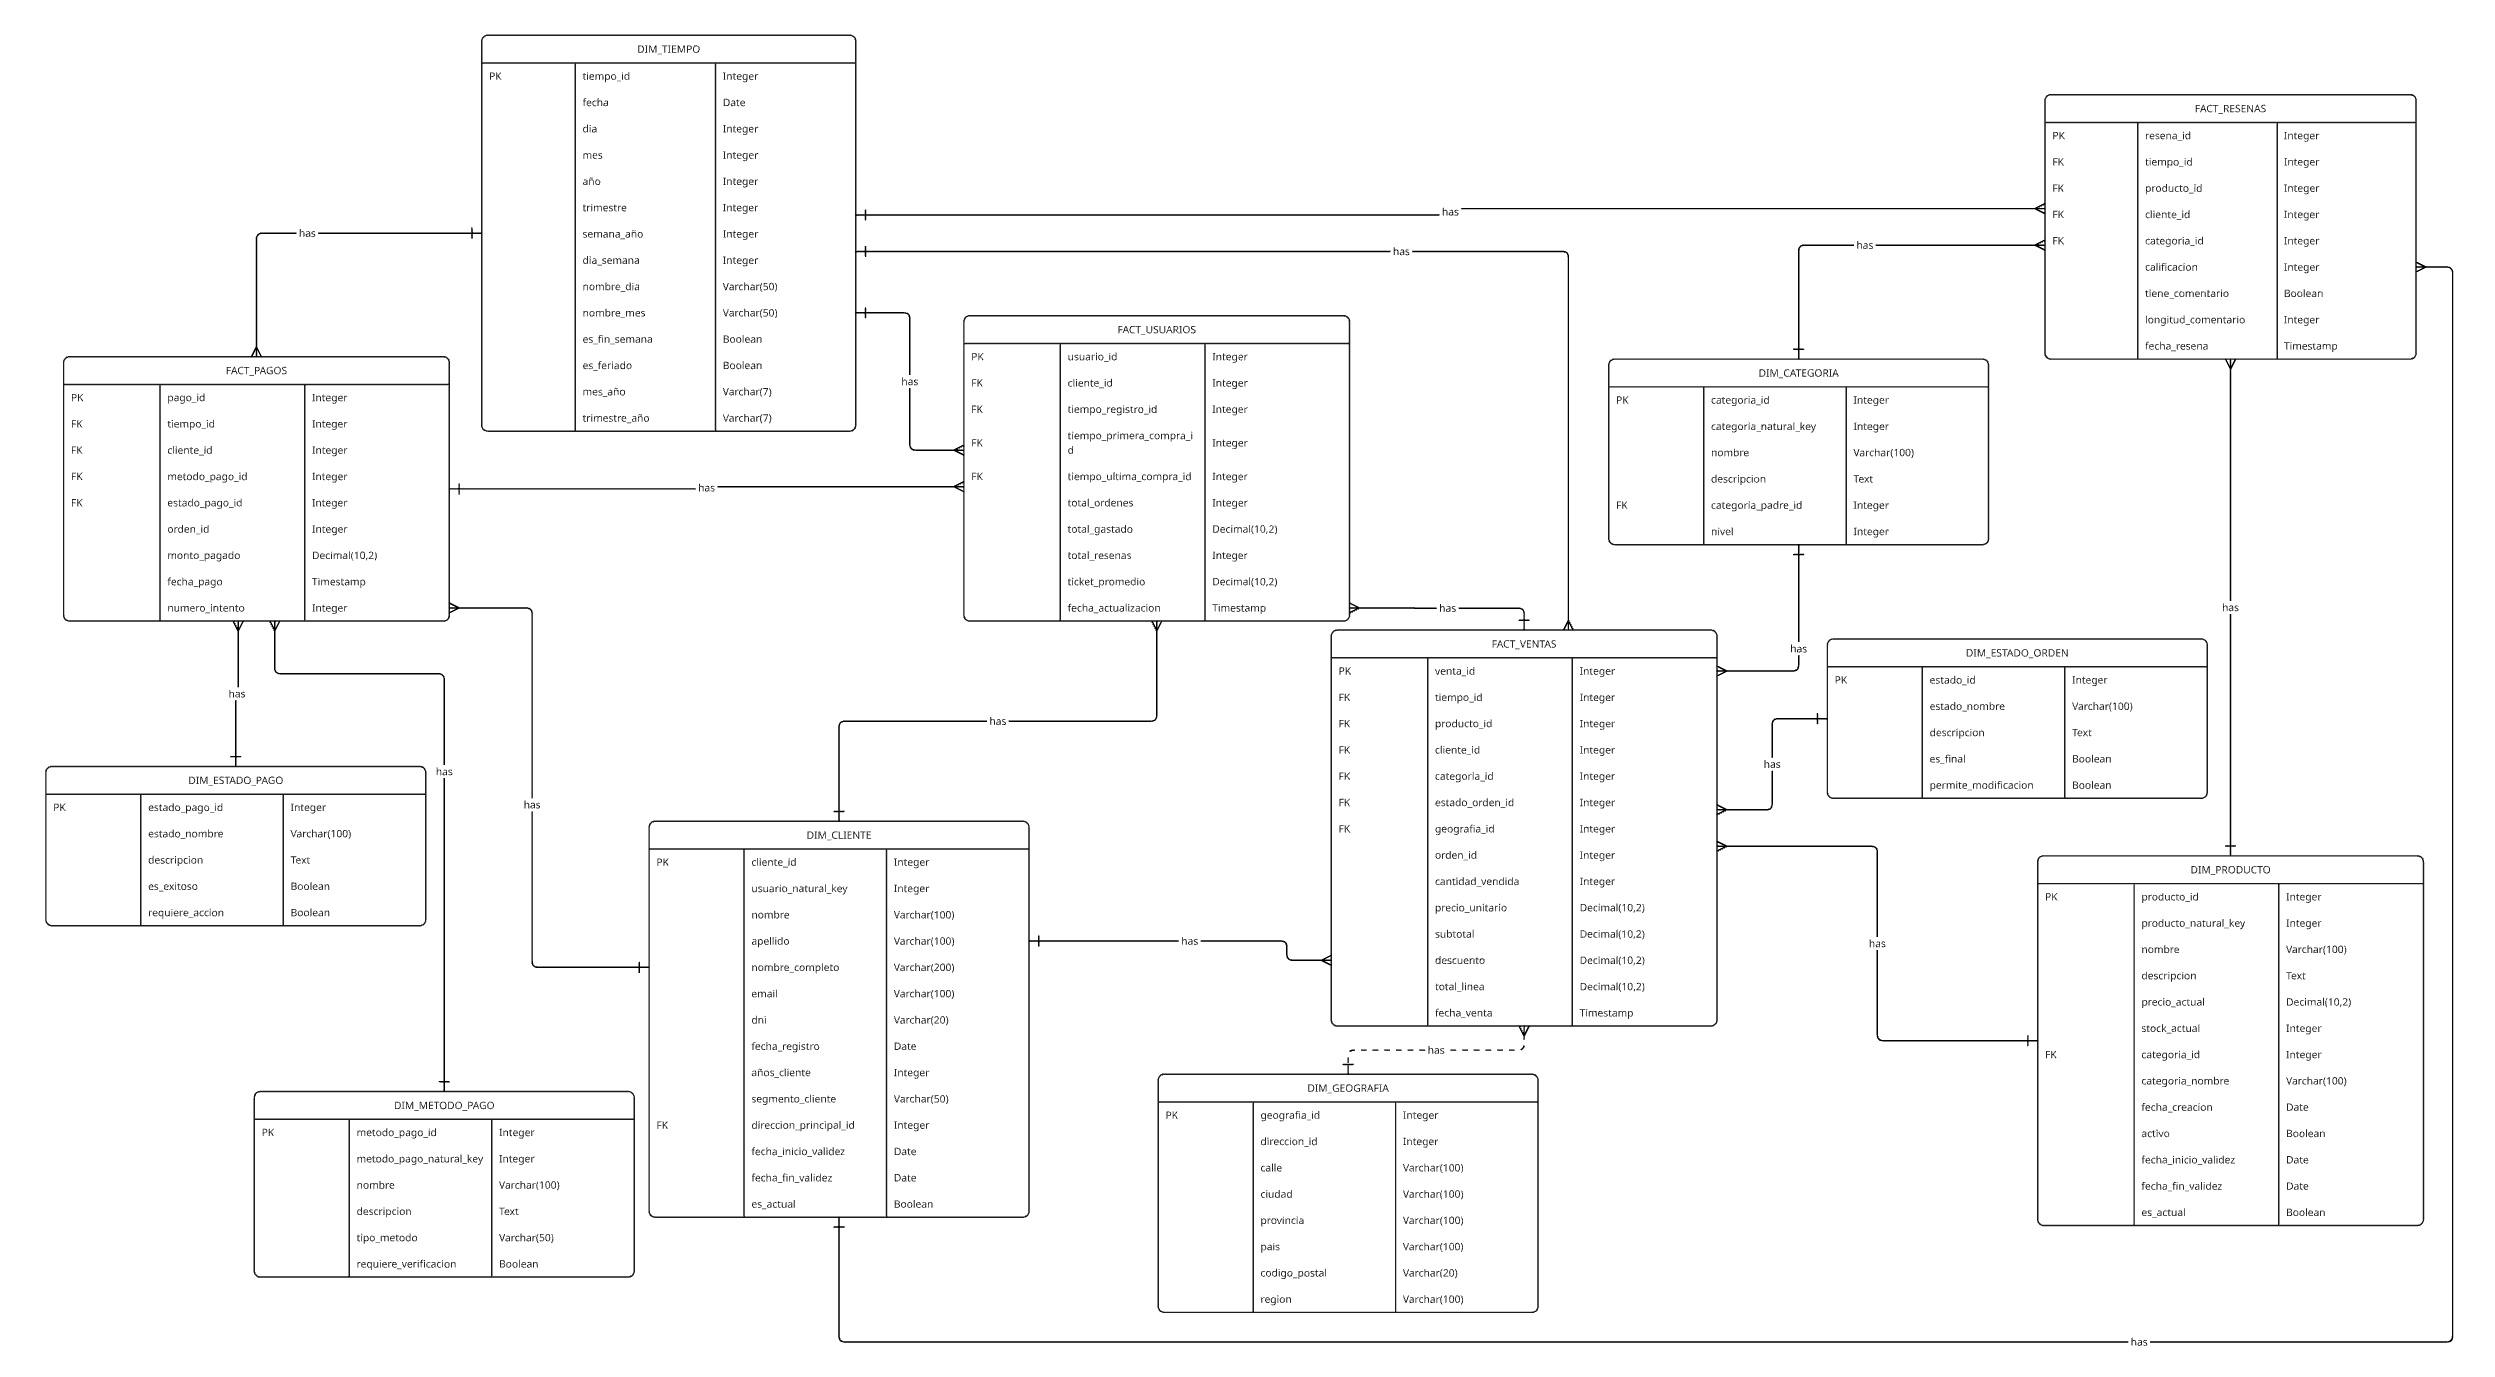

In [3]:
from IPython.display import Image, display
import os

# Obtener la ruta del archivo
ruta_der = os.path.join('assets', 'DER.png')

# Verificar que el archivo existe
if os.path.exists(ruta_der):
    display(Image(filename=ruta_der, width=1000))  # Ajusta el ancho según necesites
else:
    print(f"Error: No se encontró el archivo en {ruta_der}")

## 7. Explicación de Decisiones de Diseño

### 7.1 Elección de Hechos Centrales

#### **¿Por qué Fact_Ventas como hecho principal?**
- **Granularidad adecuada**: Una fila por línea de detalle permite análisis detallado a nivel de producto
- **Cubre múltiples preguntas**: Responde a preguntas sobre productos, categorías, ventas por tiempo, ticket promedio
- **Medidas claras**: Cantidad, precio, total son medidas naturales de una transacción de venta
- **Alta frecuencia**: Las ventas son eventos frecuentes que generan mucho volumen de datos

#### **¿Por qué Fact_Pagos como hecho separado?**
- **Granularidad diferente**: Una orden puede tener múltiples pagos (múltiples métodos)
- **Preguntas específicas**: Responde a preguntas sobre métodos de pago, estados de pago, recaudación
- **Medidas específicas**: Monto pagado, estado del pago son específicas del proceso de pago
- **Independencia**: Permite análisis de pagos sin necesidad de unir con ventas

#### **¿Por qué Fact_Resenas como hecho separado?**
- **Evento independiente**: Las reseñas son eventos separados de las ventas
- **Medidas específicas**: Calificación, comentarios son medidas propias de reseñas
- **Análisis de satisfacción**: Permite análisis de satisfacción del cliente independiente de ventas
- **Temporalidad diferente**: Una reseña puede hacerse mucho después de la compra

#### **¿Por qué Fact_Usuarios como tabla acumulativa?**
- **Agregación pre-calculada**: Evita cálculos costosos en tiempo de consulta
- **Análisis de comportamiento**: Facilita análisis de comportamiento de usuarios
- **Métricas de negocio**: CLV, frecuencia de compra, etc. se calculan una vez
- **Performance**: Consultas más rápidas para análisis de usuarios

### 7.2 Decisiones sobre Dimensiones

#### **¿Por qué Dim_Producto con SCD Tipo 2?**
- **Historial de precios**: Necesario para análisis históricos precisos
- **Análisis de cambios**: Permite analizar cómo cambian los precios en el tiempo
- **Integridad histórica**: Mantiene la integridad de los datos históricos
- **Ejemplo de uso**: "¿Cuál era el precio del producto X cuando se vendió en enero?"

#### **¿Por qué Dim_Cliente con SCD Tipo 2?**
- **Segmentación histórica**: Permite rastrear cambios en la segmentación de clientes
- **Análisis de evolución**: Analizar cómo evoluciona un cliente (Nuevo → Recurrente → VIP)
- **Precisión histórica**: Mantener el estado del cliente al momento de cada transacción
- **Ejemplo de uso**: "¿Cuántos clientes VIP había en enero vs junio?"

#### **¿Por qué Dim_Categoria con SCD Tipo 1?**
- **Estabilidad**: Las categorías raramente cambian
- **Simplicidad**: No requiere lógica compleja de historial
- **Performance**: Consultas más simples y rápidas
- **Costo-beneficio**: El costo de mantener historial no justifica el beneficio

#### **¿Por qué denormalizar categoria_nombre en Dim_Producto?**
- **Performance**: Evita JOINs en consultas frecuentes
- **Simplicidad**: Consultas más simples y legibles
- **Trade-off aceptable**: Pequeña redundancia a cambio de mejor performance
- **Uso común**: La mayoría de consultas necesitan el nombre de la categoría

### 7.3 Decisiones sobre Medidas

#### **¿Por qué almacenar subtotal y total_linea?**
- **Flexibilidad**: Permite análisis con y sin descuentos
- **Auditoría**: Facilita la auditoría de cálculos
- **Performance**: Evita recalcular en cada consulta
- **Análisis de descuentos**: Permite análisis específicos de impacto de descuentos

#### **¿Por qué precio_unitario en Fact_Ventas?**
- **Historial de precios**: Captura el precio al momento de la venta
- **Independencia**: No depende de Dim_Producto (que puede cambiar)
- **Precisión**: Garantiza que el análisis histórico sea preciso
- **Ejemplo**: Si el precio cambia, las ventas históricas mantienen el precio original

### 7.4 Decisiones sobre Granularidad

#### **Granularidad de Fact_Ventas: Línea de detalle**
- **Ventaja**: Permite análisis a nivel de producto individual
- **Flexibilidad**: Puede agregarse a nivel de orden si es necesario
- **Complejidad aceptable**: El volumen de datos es manejable
- **Análisis detallado**: Permite análisis de productos específicos en órdenes

#### **Granularidad de Fact_Pagos: Transacción individual**
- **Ventaja**: Captura cada intento de pago
- **Múltiples métodos**: Permite analizar órdenes con múltiples métodos de pago
- **Estados**: Captura el estado de cada transacción de pago
- **Auditoría**: Facilita la auditoría de pagos

### 7.5 Decisiones sobre Claves

#### **Uso de Claves Sustitutas (Surrogate Keys)**
- **Independencia**: Independiente del sistema fuente
- **Performance**: Claves enteras son más eficientes que claves compuestas
- **SCD**: Facilita la implementación de SCD Tipo 2
- **Estabilidad**: No cambian aunque cambien los datos del sistema fuente

#### **Mantenimiento de Natural Keys**
- **Referencia**: Permite referenciar el sistema fuente
- **Auditoría**: Facilita la auditoría y trazabilidad
- **Debugging**: Facilita el debugging y la resolución de problemas
- **Integración**: Facilita la integración con otros sistemas

### 7.6 Consideraciones de Performance

#### **Índices Recomendados**
- **Fact_Ventas**: Índices en tiempo_id, producto_id, cliente_id, categoria_id
- **Fact_Pagos**: Índices en tiempo_id, cliente_id, metodo_pago_id, estado_pago_id
- **Fact_Resenas**: Índices en tiempo_id, producto_id, cliente_id
- **Dim_Producto**: Índice en producto_natural_key, es_actual
- **Dim_Cliente**: Índice en usuario_natural_key, es_actual

#### **Particionamiento**
- **Fact_Ventas**: Particionar por tiempo_id (mensual o trimestral)
- **Fact_Pagos**: Particionar por tiempo_id (mensual o trimestral)
- **Fact_Resenas**: Particionar por tiempo_id (mensual o trimestral)

#### **Agregaciones Pre-calculadas**
- **Fact_Usuarios**: Tabla acumulativa para métricas de usuarios
- **Vistas materializadas**: Para consultas frecuentes (opcional)
- **Cubos OLAP**: Para análisis multidimensional (opcional)


## 8. Mapeo de Preguntas de Negocio a Hechos y Dimensiones

### 8.1 Preguntas de VENTAS

| Pregunta | Hecho | Dimensiones | Medidas |
|----------|-------|-------------|---------|
| Productos más vendidos por volumen | Fact_Ventas | Dim_Producto, Dim_Categoria | SUM(cantidad_vendida) |
| Ticket promedio por orden | Fact_Ventas | Dim_Tiempo | AVG(total_linea) |
| Categorías con mayor productos vendidos | Fact_Ventas | Dim_Categoria | SUM(cantidad_vendida), COUNT(DISTINCT producto_id) |
| Día de semana con más ventas | Fact_Ventas | Dim_Tiempo | COUNT(venta_id), SUM(total_linea) |
| Órdenes por mes y variación | Fact_Ventas | Dim_Tiempo | COUNT(DISTINCT orden_id) |

### 8.2 Preguntas de PAGOS Y TRANSACCIONES

| Pregunta | Hecho | Dimensiones | Medidas |
|----------|-------|-------------|---------|
| Métodos de pago más utilizados | Fact_Pagos | Dim_Metodo_Pago | COUNT(pago_id) |
| Monto promedio por método de pago | Fact_Pagos | Dim_Metodo_Pago | AVG(monto_pagado) |
| Órdenes con múltiples métodos | Fact_Pagos | Dim_Cliente | COUNT(DISTINCT metodo_pago_id) por orden |
| Pagos en estado Procesando/Fallido | Fact_Pagos | Dim_Estado_Pago | COUNT(pago_id) |
| Monto total recaudado por mes | Fact_Pagos | Dim_Tiempo, Dim_Estado_Pago | SUM(monto_pagado) WHERE es_exitoso = TRUE |

### 8.3 Preguntas de USUARIOS

| Pregunta | Hecho | Dimensiones | Medidas |
|----------|-------|-------------|---------|
| Usuarios registrados por mes | Fact_Usuarios | Dim_Tiempo (tiempo_registro_id) | COUNT(usuario_id) |
| Usuarios con más de una orden | Fact_Usuarios | - | COUNT WHERE total_ordenes > 1 |
| Usuarios sin compras | Fact_Usuarios | - | COUNT WHERE total_ordenes = 0 |
| Usuarios que más han gastado | Fact_Usuarios | Dim_Cliente | MAX(total_gastado) |
| Usuarios que han dejado reseñas | Fact_Resenas | Dim_Cliente | COUNT(DISTINCT cliente_id) |

### 8.4 Preguntas de PRODUCTOS Y STOCK

| Pregunta | Hecho | Dimensiones | Medidas |
|----------|-------|-------------|---------|
| Productos con alto stock y bajas ventas | Fact_Ventas, Dim_Producto | Dim_Producto | SUM(cantidad_vendida) vs stock_actual |
| Productos fuera de stock | Dim_Producto | - | COUNT WHERE stock_actual = 0 |
| Productos peor calificados | Fact_Resenas | Dim_Producto | AVG(calificacion) |
| Productos con más reseñas | Fact_Resenas | Dim_Producto | COUNT(resena_id) |
| Categoría con mayor valor económico | Fact_Ventas | Dim_Categoria | SUM(total_linea) |

## 9. Ejemplos de Consultas SQL para el Modelo Dimensional

### 9.1 Consulta: Productos más vendidos por volumen

```sql
SELECT 
    dp.nombre AS producto,
    dc.nombre AS categoria,
    SUM(fv.cantidad_vendida) AS total_vendido,
    SUM(fv.total_linea) AS total_recaudado
FROM Fact_Ventas fv
INNER JOIN Dim_Producto dp ON fv.producto_id = dp.producto_id
INNER JOIN Dim_Categoria dc ON fv.categoria_id = dc.categoria_id
WHERE dp.es_actual = TRUE
GROUP BY dp.nombre, dc.nombre
ORDER BY total_vendido DESC
LIMIT 10;
```

### 9.2 Consulta: Ticket promedio por orden por mes

```sql
SELECT 
    dt.mes_año,
    dt.nombre_mes,
    COUNT(DISTINCT fv.orden_id) AS total_ordenes,
    SUM(fv.total_linea) AS total_ventas,
    AVG(orden_totals.total_orden) AS ticket_promedio
FROM Fact_Ventas fv
INNER JOIN Dim_Tiempo dt ON fv.tiempo_id = dt.tiempo_id
INNER JOIN (
    SELECT orden_id, SUM(total_linea) AS total_orden
    FROM Fact_Ventas
    GROUP BY orden_id
) orden_totals ON fv.orden_id = orden_totals.orden_id
GROUP BY dt.mes_año, dt.nombre_mes
ORDER BY dt.mes_año;
```

### 9.3 Consulta: Métodos de pago más utilizados

```sql
SELECT 
    dmp.nombre AS metodo_pago,
    COUNT(fp.pago_id) AS total_uso,
    SUM(fp.monto_pagado) AS monto_total,
    AVG(fp.monto_pagado) AS monto_promedio
FROM Fact_Pagos fp
INNER JOIN Dim_Metodo_Pago dmp ON fp.metodo_pago_id = dmp.metodo_pago_id
INNER JOIN Dim_Estado_Pago dep ON fp.estado_pago_id = dep.estado_pago_id
WHERE dep.es_exitoso = TRUE
GROUP BY dmp.nombre
ORDER BY total_uso DESC;
```

### 9.4 Consulta: Usuarios que más han gastado

```sql
SELECT 
    dc.nombre_completo,
    dc.email,
    dc.segmento_cliente,
    fu.total_ordenes,
    fu.total_gastado,
    fu.ticket_promedio
FROM Fact_Usuarios fu
INNER JOIN Dim_Cliente dc ON fu.cliente_id = dc.cliente_id
WHERE dc.es_actual = TRUE
ORDER BY fu.total_gastado DESC
LIMIT 10;
```

### 9.5 Consulta: Productos peor calificados

```sql
SELECT 
    dp.nombre AS producto,
    dc.nombre AS categoria,
    COUNT(fr.resena_id) AS total_resenas,
    AVG(fr.calificacion) AS calificacion_promedio,
    MIN(fr.calificacion) AS calificacion_minima,
    MAX(fr.calificacion) AS calificacion_maxima
FROM Fact_Resenas fr
INNER JOIN Dim_Producto dp ON fr.producto_id = dp.producto_id
INNER JOIN Dim_Categoria dc ON fr.categoria_id = dc.categoria_id
WHERE dp.es_actual = TRUE
GROUP BY dp.nombre, dc.nombre
HAVING COUNT(fr.resena_id) >= 3
ORDER BY calificacion_promedio ASC
LIMIT 10;
```

### 9.6 Consulta: Ventas por día de la semana

```sql
SELECT 
    dt.nombre_dia,
    dt.dia_semana,
    COUNT(DISTINCT fv.orden_id) AS total_ordenes,
    SUM(fv.total_linea) AS total_recaudado,
    AVG(orden_totals.total_orden) AS ticket_promedio
FROM Fact_Ventas fv
INNER JOIN Dim_Tiempo dt ON fv.tiempo_id = dt.tiempo_id
INNER JOIN (
    SELECT orden_id, SUM(total_linea) AS total_orden
    FROM Fact_Ventas
    GROUP BY orden_id
) orden_totals ON fv.orden_id = orden_totals.orden_id
GROUP BY dt.nombre_dia, dt.dia_semana
ORDER BY dt.dia_semana;
```

### 9.7 Consulta: Análisis histórico de precios de productos

```sql
SELECT 
    dp.producto_natural_key,
    dp.nombre,
    dp.precio_actual,
    dp.fecha_inicio_validez,
    dp.fecha_fin_validez,
    LAG(dp.precio_actual) OVER (
        PARTITION BY dp.producto_natural_key 
        ORDER BY dp.fecha_inicio_validez
    ) AS precio_anterior,
    dp.precio_actual - LAG(dp.precio_actual) OVER (
        PARTITION BY dp.producto_natural_key 
        ORDER BY dp.fecha_inicio_validez
    ) AS cambio_precio
FROM Dim_Producto dp
WHERE dp.producto_natural_key = 1  -- Ejemplo para un producto específico
ORDER BY dp.fecha_inicio_validez;
```

## 10. Resumen Ejecutivo

### 10.1 Modelo Dimensional Propuesto

El modelo dimensional propuesto sigue la metodología de Kimball y está compuesto por:

**4 Tablas de Hechos:**
1. **Fact_Ventas**: Hecho principal para análisis de ventas
2. **Fact_Pagos**: Hecho para análisis de transacciones de pago
3. **Fact_Resenas**: Hecho para análisis de satisfacción del cliente
4. **Fact_Usuarios**: Tabla acumulativa para métricas de usuarios

**8 Dimensiones:**
1. **Dim_Tiempo**: Dimensión de tiempo (estática)
2. **Dim_Producto**: Dimensión de productos (SCD Tipo 2)
3. **Dim_Cliente**: Dimensión de clientes (SCD Tipo 2)
4. **Dim_Categoria**: Dimensión de categorías (SCD Tipo 1)
5. **Dim_Metodo_Pago**: Dimensión de métodos de pago (SCD Tipo 1)
6. **Dim_Estado_Orden**: Dimensión de estados de orden
7. **Dim_Estado_Pago**: Dimensión de estados de pago
8. **Dim_Geografia**: Dimensión geográfica

### 10.2 Capacidades del Modelo

El modelo propuesto permite responder a **todas las 20 preguntas de negocio** identificadas:

✅ **Ventas**: Productos más vendidos, ticket promedio, categorías, análisis temporal
✅ **Pagos**: Métodos de pago, montos, estados, recaudación
✅ **Usuarios**: Registros, comportamiento, gastos, participación
✅ **Productos**: Stock, calificaciones, reseñas, valor económico

### 10.3 Ventajas del Diseño

1. **Flexibilidad**: Permite análisis desde múltiples perspectivas
2. **Performance**: Optimizado para consultas analíticas
3. **Escalabilidad**: Diseñado para crecer con el negocio
4. **Mantenibilidad**: Estructura clara y bien documentada
5. **Historial**: Mantiene historial de cambios importantes (SCD Tipo 2)

---